In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [ ]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/datasets/train.csv", parse_dates=["date"])
test = pd.read_csv("/content/drive/MyDrive/datasets/test.csv", parse_dates=["date"])


In [ ]:
df = pd.concat([train, test])

In [ ]:
df.sample(5)

,date,store,item,sales,id
853633,2015-06-11,8,47,32.000,NaN
226072,2017-01-14,4,13,72.000,NaN
777613,2017-04-13,6,43,55.000,NaN
127490,2017-02-05,10,7,57.000,NaN
81112,2015-02-08,5,5,9.000,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    958000 non-null  datetime64[ns]
 1   store   958000 non-null  int64         
 2   item    958000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      45000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.9 MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
store,958000.000,5.500,2.872,1.000,3.000,5.500,8.000,10.000
item,958000.000,25.500,14.431,1.000,13.000,25.500,38.000,50.000
sales,913000.000,52.250,28.801,0.000,30.000,47.000,70.000,231.000
id,45000.000,22499.500,12990.525,0.000,11249.750,22499.500,33749.250,44999.000


In [ ]:
df["date"].min() # Timestamp('2013-01-01 00:00:00')
df["date"].max() # Timestamp('2018-03-31 00:00:00')

Timestamp('2018-03-31 00:00:00')

In [ ]:
df[["store"]].nunique() # 10
df[["item"]].nunique() # 50

item    50
dtype: int64

In [ ]:
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [ ]:
df.groupby(["store", "item"]).agg({"sales":[ "sum", "mean", "median", "std"]})



sales                     
                  sum   mean median    std
store item                                
1     1     36468.000 19.972 19.000  6.741
      2     97050.000 53.149 52.000 15.006
      3     60638.000 33.208 33.000 10.073
      4     36440.000 19.956 20.000  6.641
      5     30335.000 16.613 16.000  5.672
...               ...    ...    ...    ...
10    46   120601.000 66.047 65.000 18.115
      47    45204.000 24.756 24.000  7.925
      48   105570.000 57.815 57.000 15.899
      49    60317.000 33.032 32.000 10.092
      50   135192.000 74.037 73.000 19.938

[500 rows x 4 columns]

In [ ]:
def create_date_features(dataframe):
    dataframe['month'] = dataframe.date.dt.month
    dataframe['day_of_month'] = dataframe.date.dt.day
    dataframe['day_of_year'] = dataframe.date.dt.dayofyear
    dataframe['week_of_year'] = dataframe.date.dt.weekofyear
    dataframe['day_of_week'] = dataframe.date.dt.dayofweek
    dataframe['year'] = dataframe.date.dt.year
    dataframe["is_wknd"] = dataframe.date.dt.weekday // 4
    dataframe['is_month_start'] = dataframe.date.dt.is_month_start.astype(int)
    dataframe['is_month_end'] = dataframe.date.dt.is_month_end.astype(int)
    return dataframe

In [ ]:
df = create_date_features(df)


<ipython-input-16-ec2401123914>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  dataframe['week_of_year'] = dataframe.date.dt.weekofyear


In [ ]:
df.groupby(["store", "item", "month"]).agg({"sales":[ "sum", "mean", "median", "std"]})


sales                     
                       sum   mean median    std
store item month                               
1     1    1      2125.000 13.710 13.000  4.397
           2      2063.000 14.631 14.000  4.668
           3      2728.000 17.600 17.000  4.545
           4      3118.000 20.787 20.000  4.894
           5      3448.000 22.245 22.000  6.565
...                    ...    ...    ...    ...
10    50   8     13108.000 84.568 85.000 15.677
           9     11831.000 78.873 79.000 15.207
           10    11322.000 73.045 72.000 14.209
           11    11549.000 76.993 77.000 16.254
           12     8724.000 56.284 56.000 11.783

[6000 rows x 4 columns]

In [ ]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [ ]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)


In [ ]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [ ]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [ ]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [ ]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [ ]:
df = roll_mean_features(df, [365, 546])

In [ ]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

In [ ]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [ ]:
df = ewm_features(df, alphas, lags)


In [ ]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])


In [ ]:
df.shape # (958000, 146)

(958000, 146)

In [ ]:
df['sales'] = np.log1p(df["sales"].values)

In [ ]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


In [ ]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [ ]:
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [ ]:
test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [ ]:
train = df.loc[(df["date"] < "2017-01-01"), :]
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]


In [ ]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [ ]:
y_train = train['sales']
X_train = train[cols]


In [ ]:
y_val = val['sales']
X_val = val[cols]


In [ ]:
y_train.shape, X_train.shape, y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

In [ ]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_round': 200,
              'nthread': -1}


In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)

In [ ]:
lgbval = lgb.Dataset(data=X_val, label=y_val, reference=lgbtrain, feature_name=cols)

In [ ]:
# model = lgb.train(lgb_params, lgbtrain,
#                   valid_sets=[lgbtrain, lgbval],
#                   num_boost_round=lgb_params['num_boost_round'],
#                   early_stopping_rounds=lgb_params['early_stopping_rounds'],
#                   feval=lgbm_smape,
#                   verbose_eval=100)

# model = lgb.train(lgb_params, lgbtrain, valid_sets=[lgbtrain, lgbval], feval=lgbm_smape, verbose_eval=100)
model = lgb.train(params=lgb_params, train_set=lgbtrain, valid_sets=[lgbtrain, lgbval], feval=lgbm_smape)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.0 MB/s eta 0:00:00


In [ ]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [ ]:
smape(np.expm1(y_pred_val), np.expm1(y_val)) # 13.517766454941283

13.522657417382797

In [ ]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

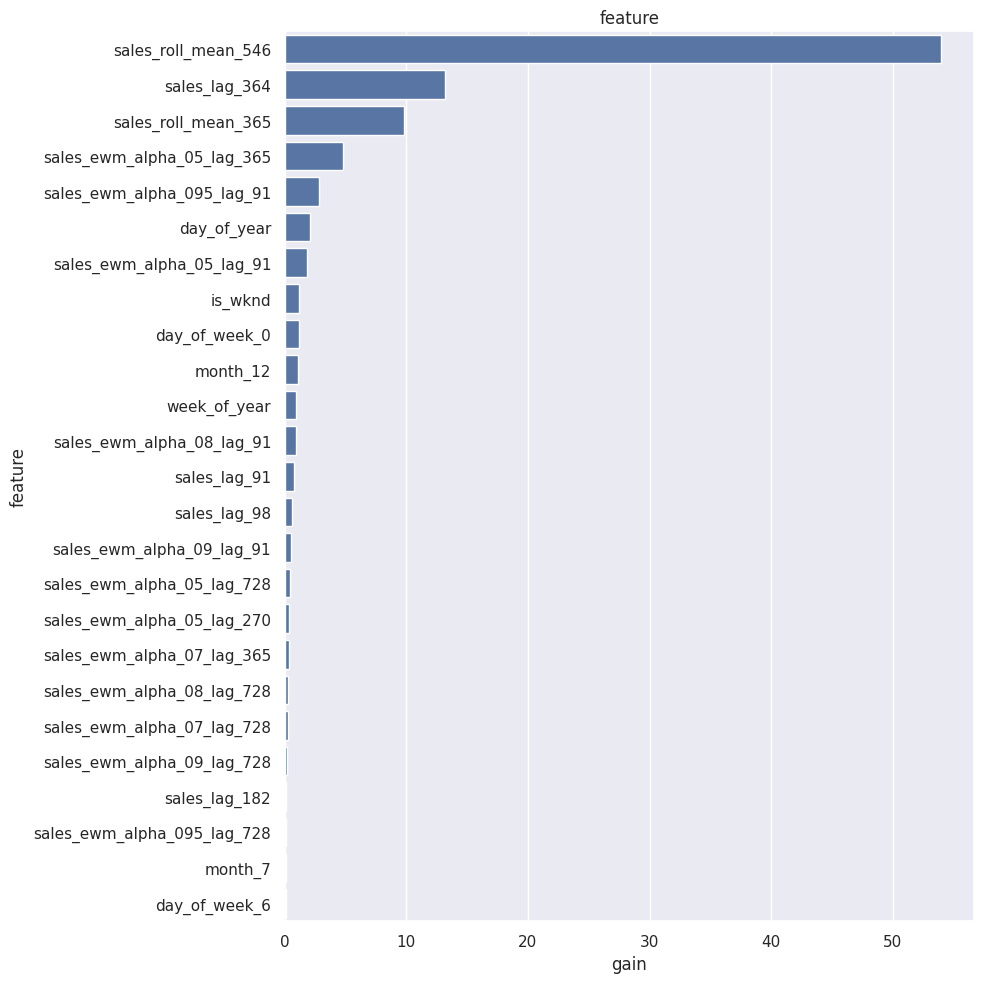

,feature,split,gain
17,sales_roll_mean_546,6940,53.959
13,sales_lag_364,5933,13.181
16,sales_roll_mean_365,5493,9.838
60,sales_ewm_alpha_05_lag_365,1752,4.821
18,sales_ewm_alpha_095_lag_91,1016,2.801
...,...,...,...
81,item_9,23,0.000
98,item_26,22,0.000
133,month_4,23,0.000
115,item_43,19,0.000


In [ ]:
plot_lgb_importances(model, num=10, plot=True)

In [ ]:
train = df.loc[~df["sales"].isna()]
Y_train = train['sales']
X_train = train[cols]

In [ ]:
test = df.loc[df.sales.isna()]
X_test = test[cols]

In [ ]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [ ]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)


In [ ]:
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)


In [ ]:
submission_df = test.loc[:, ["id", "sales"]]
submission_df['sales'] = np.expm1(test_preds)

In [ ]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 0 to 44999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      45000 non-null  float64
 1   sales   45000 non-null  float64
dtypes: float64(2)
memory usage: 1.0 MB


In [ ]:
submission_df['id'] = submission_df["id"].astype("int64")
submission_df

,id,sales
0,0,12.792
1,1,14.154
2,2,14.989
3,3,14.368
4,4,16.046
...,...,...
44995,44995,73.069
44996,44996,75.334
44997,44997,79.428
44998,44998,83.213
